In [1]:
import torch
device = "cuda:0"
torch.cuda.set_device(device)

In [2]:
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM

from modules.lm_head import LMHeadModel
from modules.modeling_phi import PhiForCausalLM
from utils.config import Config
teacher_model = PhiForCausalLM.from_pretrained(
    "microsoft/phi-1.5", attn_implementation="eager"
).to(device)
teacher_model.eval()
teacher_model.requires_grad_(False)

dataset = load_dataset("stas/openwebtext-10k")["train"]
dataloader = DataLoader(dataset, batch_size=4)

tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5")



/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PhiForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of 

In [4]:
def init_weights(module):
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)
    elif isinstance(module, torch.nn.LayerNorm):
        torch.nn.init.ones_(module.weight)
        torch.nn.init.zeros_(module.bias)
    elif isinstance(module, torch.nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


In [3]:

model_config = Config.from_json("assets/sample_config.json")
model_config = AutoConfig.from_pretrained("/common-repos/xLSTM-7b")
model_config.num_blocks = 16
model_config.head_dim = 256
model_config.num_heads = 8
model_config.embedding_dim = 2048
model_config.vocab_size = teacher_model.config.vocab_size
student_model = AutoModelForCausalLM.from_pretrained("/common-repos/xLSTM-7b", config=model_config, ignore_mismatched_sizes=True).to(device)



#student_model.apply(init_weights)
student_model.to(device)
student_model.requires_grad_(True)


Loading checkpoint shards: 100%|██████████| 6/6 [00:00<00:00,  6.57it/s]
Some weights of the model checkpoint at /common-repos/xLSTM-7b were not used when initializing xLSTMForCausalLM: ['backbone.blocks.16.ffn.proj_down.weight', 'backbone.blocks.16.ffn.proj_up.weight', 'backbone.blocks.16.ffn.proj_up_gate.weight', 'backbone.blocks.16.mlstm_layer.fgate_preact.bias', 'backbone.blocks.16.mlstm_layer.fgate_preact.weight', 'backbone.blocks.16.mlstm_layer.igate_preact.bias', 'backbone.blocks.16.mlstm_layer.igate_preact.weight', 'backbone.blocks.16.mlstm_layer.k.weight', 'backbone.blocks.16.mlstm_layer.multihead_norm.weight', 'backbone.blocks.16.mlstm_layer.ogate_preact.weight', 'backbone.blocks.16.mlstm_layer.out_proj.weight', 'backbone.blocks.16.mlstm_layer.q.weight', 'backbone.blocks.16.mlstm_layer.v.weight', 'backbone.blocks.16.norm_ffn.weight', 'backbone.blocks.16.norm_mlstm.weight', 'backbone.blocks.17.ffn.proj_down.weight', 'backbone.blocks.17.ffn.proj_up.weight', 'backbone.blocks.17.

xLSTMForCausalLM(
  (backbone): xLSTMModel(
    (embeddings): Embedding(51200, 2048)
    (blocks): ModuleList(
      (0-15): 16 x mLSTMBlock(
        (norm_mlstm): RMSNorm()
        (mlstm_layer): mLSTMLayer(
          (q): Linear(in_features=2048, out_features=1024, bias=False)
          (k): Linear(in_features=2048, out_features=1024, bias=False)
          (v): Linear(in_features=2048, out_features=2048, bias=False)
          (ogate_preact): Linear(in_features=2048, out_features=2048, bias=False)
          (igate_preact): Linear(in_features=2048, out_features=8, bias=True)
          (fgate_preact): Linear(in_features=2048, out_features=8, bias=True)
          (ogate_act_fn): Sigmoid()
          (mlstm_backend): mLSTMBackend(mLSTMBackendConfig(chunkwise_kernel='chunkwise--triton_xl_chunk', sequence_kernel='native_sequence__triton', step_kernel='triton', mode='inference', chunk_size=64, return_last_states=True, autocast_kernel_dtype='bfloat16', eps=1e-06, inference_state_dtype='float32

In [14]:
path = "checkpoints/epoch_5.pt"
checkpoint = torch.load(path, map_location=device, weights_only=True)
model_state_to_load = checkpoint['model_state_dict']
#start_epoch = checkpoint['epoch']-1
#start_idx = checkpoint['idx']-1


student_model.load_state_dict(model_state_to_load)
student_model.requires_grad_(True)

xLSTMForCausalLM(
  (backbone): xLSTMModel(
    (embeddings): Embedding(51200, 2048)
    (blocks): ModuleList(
      (0-15): 16 x mLSTMBlock(
        (norm_mlstm): RMSNorm()
        (mlstm_layer): mLSTMLayer(
          (q): Linear(in_features=2048, out_features=1024, bias=False)
          (k): Linear(in_features=2048, out_features=1024, bias=False)
          (v): Linear(in_features=2048, out_features=2048, bias=False)
          (ogate_preact): Linear(in_features=2048, out_features=2048, bias=False)
          (igate_preact): Linear(in_features=2048, out_features=8, bias=True)
          (fgate_preact): Linear(in_features=2048, out_features=8, bias=True)
          (ogate_act_fn): Sigmoid()
          (mlstm_backend): mLSTMBackend(mLSTMBackendConfig(chunkwise_kernel='chunkwise--triton_xl_chunk', sequence_kernel='native_sequence__triton', step_kernel='triton', mode='inference', chunk_size=64, return_last_states=True, autocast_kernel_dtype='bfloat16', eps=1e-06, inference_state_dtype='float32

In [9]:
import torch

# Assuming student_model is loaded and on the correct device
# student_model.load_state_dict(checkpoint['model_state_dict'])
# student_model.to(device)

print("--- Checking for NaN/Inf in Model Parameters ---")
found_nan_inf = False
for name, param in student_model.named_parameters():
    if not torch.all(torch.isfinite(param.data)):
        print(f"WARNING: Parameter '{name}' contains NaN or Inf values!")
        # You can print more details if needed:
        # print(f"  Number of NaNs: {torch.isnan(param.data).sum().item()}")
        # print(f"  Number of Infs: {torch.isinf(param.data).sum().item()}")
        found_nan_inf = True
    # Optional: Check if all values in a parameter are zero (as we did before)
    # if param.data.norm().item() == 0.0:
    #     print(f"INFO: Parameter '{name}' is all zeros.")

if not found_nan_inf:
    print("No NaN or Inf values found in model parameters. Good!")
else:
    print("CRITICAL: NaN or Inf values detected in loaded weights! This will cause issues.")
print("----------------------------------------------")

--- Checking for NaN/Inf in Model Parameters ---
No NaN or Inf values found in model parameters. Good!
----------------------------------------------


In [7]:


print(next(student_model.parameters()).device)

cuda:0


In [15]:
def collate_fn(batch):
    texts = [item['text'] for item in batch]
    encodings = tokenizer(
        texts,
        return_tensors="pt",
        truncation=True,
        padding='longest'
    )
    return {
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"]
    }
 

In [16]:

tokenizer.pad_token = tokenizer.eos_token
dataloader = DataLoader(dataset, batch_size = 1, shuffle = True, collate_fn = collate_fn)

In [18]:
import math
num_teacher_layers = len(teacher_model.model.layers)
num_student_layers = len(student_model.backbone.blocks)


In [9]:
print(num_student_layers, num_teacher_layers)

16 24


In [19]:
parameters = student_model.parameters()
optimizer = optim.Adam(params = parameters, lr = 5e-6)

vocab_size = teacher_model.vocab_size

In [11]:
print(student_model.config.vocab_size)

51200


In [21]:
def logit_loss(student_logits, teacher_logits, input_ids, epoch, temp=2.0, ce_loss_weight=0.5, soft_target_loss_weight = 0.05, vocab_size = teacher_model.vocab_size ):
    
        ce_loss = nn.CrossEntropyLoss()
        kl_loss_fn = nn.KLDivLoss(reduction = "batchmean")
        
        labels = input_ids[:, 1:].contiguous()
        
        shift_student_logits = student_logits[:, :-1, :].contiguous()
        shift_teacher_logits = teacher_logits[:, :-1, :].contiguous()
        
        label_loss = ce_loss(shift_student_logits.view(-1, vocab_size), labels.view(-1))
        
        soft_targets = nn.functional.softmax(shift_teacher_logits/temp, dim = -1)
        soft_probs = nn.functional.log_softmax(shift_student_logits/temp, dim = -1)
        
        if epoch > 2:
                soft_targets_loss = kl_loss_fn(soft_probs, soft_targets)*(temp ** 2)
        else: 
                soft_targets_loss = 0.0
        
        loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

       # print(f"Iter: {idx}, Current loss: {loss.item()}, CE Loss: {label_loss.item()}, KL Loss: {soft_targets_loss.item()}")
        return loss, label_loss, soft_targets_loss

In [13]:
from torch.cuda.amp import autocast

In [22]:
import os
checkpoints_without_hidden = "./checkpoints_logits"

os.makedirs(checkpoints_without_hidden, exist_ok = True)

In [24]:
torch.autograd.set_detect_anomaly(True)

accumulation_steps = 16

freeze_mlp = True
student_model.to(device)
num_epochs = 10
alpha = 0.3

start_epoch = 0
start_idx = 0
# sys.exit() # Uncomment to stop after this test
with torch.autocast(device_type=device, dtype=torch.bfloat16):
    for epoch in range(start_epoch, num_epochs):
        torch.cuda.empty_cache()
        student_model.train()
        for idx, batch in enumerate(dataloader):
            if idx < start_idx:
                continue
            start_idx = 0
            batch = {k: v.to(device) for k, v in batch.items()}
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            
    
            student_outputs = student_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=False,
                    use_cache=False,
                    output_attention_results=False
                )
                
            student_logits = student_outputs.logits
            with torch.no_grad():
                teacher_outputs = teacher_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=False,
                    use_cache=False,
                    output_attention_results=False
                )
            teacher_logits = teacher_outputs.logits
            
            loss, loss_CE, loss_KL = logit_loss(student_logits, teacher_logits, input_ids, epoch)
            
            loss = loss / accumulation_steps
            
            loss.backward()
            
           
            if  (idx+1) % accumulation_steps == 0 or idx ==0:
                    
                    if (idx+1) % 320 == 0:
                        print("hello")
                        checkpoint_path = os.path.join(checkpoints_without_hidden, f"(5)epoch_{epoch}idx_{idx}.pt")
                        loss = loss.item() * accumulation_steps
                        torch.save({'idx': idx + 1,
                        'epoch': epoch + 1, 
                        'model_state_dict': student_model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss,
                        }, checkpoint_path) 

                    optimizer.step()
                    optimizer.zero_grad()

            
                    print(f"Epoch/Iteration: {epoch} / { (idx + 1) // accumulation_steps } | Effective Batch Loss: {loss.item() * accumulation_steps:.4f} ...\n")
        
        checkpoint_path = os.path.join(checkpoints_without_hidden, f"epoch_{epoch+1}.pt")
    
        torch.save({'epoch': epoch + 1, 
                    'model_state_dict': student_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item(),
                    }, checkpoint_path) 
            
        
    
    

Epoch/Iteration: 0 / 0 | Effective Batch Loss: 5.4036 ...

Epoch/Iteration: 0 / 1 | Effective Batch Loss: 5.3874 ...

Epoch/Iteration: 0 / 2 | Effective Batch Loss: 5.3771 ...

Epoch/Iteration: 0 / 3 | Effective Batch Loss: 5.3602 ...

Epoch/Iteration: 0 / 4 | Effective Batch Loss: 5.3517 ...

Epoch/Iteration: 0 / 5 | Effective Batch Loss: 5.3505 ...

Epoch/Iteration: 0 / 6 | Effective Batch Loss: 5.3565 ...

Epoch/Iteration: 0 / 7 | Effective Batch Loss: 5.3290 ...

Epoch/Iteration: 0 / 8 | Effective Batch Loss: 5.3450 ...

Epoch/Iteration: 0 / 9 | Effective Batch Loss: 5.2953 ...

Epoch/Iteration: 0 / 10 | Effective Batch Loss: 5.2561 ...

Epoch/Iteration: 0 / 11 | Effective Batch Loss: 5.2904 ...

Epoch/Iteration: 0 / 12 | Effective Batch Loss: 5.2653 ...

Epoch/Iteration: 0 / 13 | Effective Batch Loss: 5.2722 ...

Epoch/Iteration: 0 / 14 | Effective Batch Loss: 5.2683 ...

Epoch/Iteration: 0 / 15 | Effective Batch Loss: 5.2978 ...

Epoch/Iteration: 0 / 16 | Effective Batch Loss: 5.

KeyboardInterrupt: 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

from modules.modeling_phi import PhiForCausalLM # Your custom model

# --- Configuration ---
DEVICE = "cuda:1"
TOKENIZER_NAME = "microsoft/phi-1_5"
STUDENT_MODEL_NAME = "microsoft/phi-1_5"
# For this test, we won't use a teacher model or KL loss.
DATASET_NAME = "stas/openwebtext-10k"
MAX_SEQ_LENGTH = 64 # Keep sequences short for faster iteration in this test
BATCH_SIZE = 8      # Small batch size for this test
LEARNING_RATE = 5e-5 # A slightly higher LR might be okay for a smaller problem
NUM_EPOCHS = 10      # Just a few epochs for testing
LOG_INTERVAL = 10
GRADIENT_ACCUMULATION_STEPS = 1 # No accumulation for simplicity here, unless BATCH_SIZE is 1

# ---- MODIFICATION FOR "FEW LOGITS" TRAINING ----
DEBUG_VOCAB_SIZE = 100 # Train on the first 50 token IDs only
# -------------------------------------------------

# --- Initialize Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
actual_tokenizer_vocab_size = tokenizer.vocab_size # Store original before potential modification
print(f"Original tokenizer vocab size: {actual_tokenizer_vocab_size}, len(tokenizer): {len(tokenizer)}")


# --- Load Student Model ---
print(f"\n--- Loading Student Model ({STUDENT_MODEL_NAME}) on {DEVICE} ---")
student_model_full_vocab = PhiForCausalLM.from_pretrained(
    STUDENT_MODEL_NAME,
    attn_implementation="eager",
    trust_remote_code=True
)
original_student_vocab_size = student_model_full_vocab.config.vocab_size
print(f"Original student model vocab size: {original_student_vocab_size}")

# --- !!! TEMPORARILY RESIZE STUDENT MODEL'S VOCAB FOR DEBUGGING !!! ---
# This will reinitialize the lm_head and token embeddings for the new size.
# We are effectively creating a new, smaller model head.
if original_student_vocab_size != DEBUG_VOCAB_SIZE:
    print(f"Resizing student model from {original_student_vocab_size} to DEBUG_VOCAB_SIZE {DEBUG_VOCAB_SIZE}")
    student_model_full_vocab.resize_token_embeddings(DEBUG_VOCAB_SIZE)
    # The lm_head (output layer) should also be adjusted.
    # For Phi, if lm_head is tied or is student_model.embed_out, resize_token_embeddings handles it.
    # If it's a separate nn.Linear called 'lm_head', we might need to replace it.
    if hasattr(student_model_full_vocab, 'lm_head') and isinstance(student_model_full_vocab.lm_head, nn.Linear):
        print("Replacing lm_head for student model.")
        hidden_size = student_model_full_vocab.lm_head.in_features
        student_model_full_vocab.lm_head = nn.Linear(hidden_size, DEBUG_VOCAB_SIZE, bias=False) # Or existing bias setting
    elif hasattr(student_model_full_vocab, 'embed_out') and isinstance(student_model_full_vocab.embed_out, nn.Linear): # For some Phi versions
        print("Replacing embed_out (LM head) for student model.")
        hidden_size = student_model_full_vocab.embed_out.in_features
        student_model_full_vocab.embed_out = nn.Linear(hidden_size, DEBUG_VOCAB_SIZE, bias=False)
    else:
        print("LM head assumed to be tied or handled by resize_token_embeddings for student.")
    # Update the config to reflect the new vocab size
    student_model_full_vocab.config.vocab_size = DEBUG_VOCAB_SIZE
else:
    print("Student model already has the DEBUG_VOCAB_SIZE. No resize needed.")

student_model = student_model_full_vocab.to(DEVICE) # Now move the modified model
student_model.train()
student_model.requires_grad_(True)
print(f"Student model configured with DEBUG_VOCAB_SIZE: {student_model.config.vocab_size}")
if hasattr(student_model, 'lm_head') and isinstance(student_model.lm_head, nn.Linear):
    print(f"Student LM head output features: {student_model.lm_head.out_features}")


# --- Dataset and DataLoader ---
print("\n--- Preparing Data ---")
dataset = load_dataset(DATASET_NAME)["train"].select(range(10000)) # Use a small subset of data for faster testing

def collate_fn_debug_vocab(batch):
    texts = [item['text'] for item in batch]
    encodings = tokenizer(
        texts,
        return_tensors="pt",
        truncation=True,
        padding='longest',
        max_length=MAX_SEQ_LENGTH
    )
    # --- !!! FILTER/CLAMP TOKEN IDS FOR DEBUGGING !!! ---
    # Ensure input_ids and thus labels are within [0, DEBUG_VOCAB_SIZE - 1]
    # Method 1: Clamp (simpler, but changes token meaning)
    encodings["input_ids"] = torch.clamp(encodings["input_ids"], max=DEBUG_VOCAB_SIZE - 1)
    # Method 2: Filter batches (more complex, might lead to very few usable batches)
    #   - You'd check if all tokens in encodings["input_ids"] are < DEBUG_VOCAB_SIZE.
    #   - This is often too restrictive. Clamping is easier for this specific test.

    return {
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"]
    }

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_debug_vocab, num_workers=2)
print(f"Lenght of dataloader is: {len(dataloader)}")
optimizer = optim.Adam(student_model.parameters(), lr=LEARNING_RATE)

# --- CE Loss Function (No KL) ---
# This function assumes student_logits already have the reduced vocab dimension
def ce_loss_for_debug_vocab(student_logits_reduced_vocab, input_ids_clamped):
    ce_loss_criterion = nn.CrossEntropyLoss()
    # Labels are derived from input_ids_clamped, so they are also within the reduced vocab
    labels = input_ids_clamped[:, 1:].contiguous()
    shift_student_logits = student_logits_reduced_vocab[:, :-1, :].contiguous() # Logits are already reduced

    calculated_ce_loss = ce_loss_criterion(
        shift_student_logits.view(-1, DEBUG_VOCAB_SIZE), # Last dim is DEBUG_VOCAB_SIZE
        labels.view(-1)
    )
    return calculated_ce_loss

# --- Training Loop ---
#print(f"\n--- Starting DEBUG Training (Vocab Size: {DEBUG_VOCAB_SIZE}) for {NUM_EPOCHS} epochs ---")
losses = torch.zeros(NUM_EPOCHS)
for epoch in range(NUM_EPOCHS):
    student_model.train()
    loss_per_epoch = torch.zeros(len(dataloader))
    for idx, batch in enumerate(dataloader):
        optimizer.zero_grad()

        input_ids_clamped = batch["input_ids"].to(DEVICE) # Already clamped in collate_fn
        attention_mask = batch["attention_mask"].to(DEVICE)

        # Student forward pass - model now outputs logits for DEBUG_VOCAB_SIZE
        student_outputs = student_model(
            input_ids=input_ids_clamped, # Use clamped input_ids
            attention_mask=attention_mask,
            output_hidden_states=False,
            use_cache=False,
            output_attentions=False
        )
        student_logits_reduced_vocab = student_outputs.logits # Shape: [B, S, DEBUG_VOCAB_SIZE]
        
        # Loss calculation (CE Only on reduced vocabulary)
        loss = ce_loss_for_debug_vocab(
            student_logits_reduced_vocab,
            input_ids_clamped
        )
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
        optimizer.step()
        
        if idx % LOG_INTERVAL == 0:
            print(f"Epoch: {epoch+1}/{NUM_EPOCHS}, Iter: {idx}/{len(dataloader)} | "
                  f"Loss (CE on {DEBUG_VOCAB_SIZE} logits): {loss.item():.4f}")
            
        loss_per_epoch[idx] = loss.item()

  
    print(f"--- End of Epoch {epoch+1} ---")
    losses[epoch] = torch.mean(loss_per_epoch)

     


# !!! IMPORTANT: Remember to revert these model/tokenizer changes for actual full training !!!
# You would typically load the original student_model again without resizing for the real run.

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Original tokenizer vocab size: 50257, len(tokenizer): 50295

--- Loading Student Model (microsoft/phi-1_5) on cuda:1 ---


PhiForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Original student model vocab size: 51200
Resizing student model from 51200 to DEBUG_VOCAB_SIZE 100
Replacing lm_head for student model.
Student model configured with DEBUG_VOCAB_SIZE: 100
Student LM head output features: 100

--- Preparing Data ---
Lenght of dataloader is: 1250
Epoch: 1/10, Iter: 0/1250 | Loss (CE on 100 logits): 4.8763
Epoch: 1/10, Iter: 10/1250 | Loss (CE on 100 logits): 0.6374
Epoch: 1/10, Iter: 20/1250 | Loss (CE on 100 logits): 0.5382


KeyboardInterrupt: 

In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [16]:
def plot(epochs, values):
    
    plt.plot(epochs, values.detach().numpy(), marker = 'o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss function")
    plt.legend()
    plt.show()


/tmp/ipykernel_2288835/2718204610.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


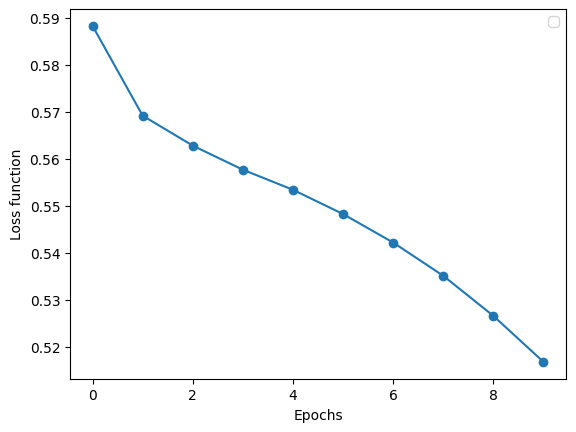

In [17]:
epochs = np.arange(0, 10, 1)

plot(epochs, losses)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

from modules.modeling_phi import PhiForCausalLM # Your custom model

# --- Configuration ---
DEVICE = "cuda:1"
TOKENIZER_NAME = "microsoft/phi-1_5"
STUDENT_MODEL_NAME = "microsoft/phi-1_5"
# For this test, we won't use a teacher model or KL loss.
DATASET_NAME = "stas/openwebtext-10k"
MAX_SEQ_LENGTH = 64 # Keep sequences short for faster iteration in this test
BATCH_SIZE = 8      # Small batch size for this test
LEARNING_RATE = 5e-5 # A slightly higher LR might be okay for a smaller problem
NUM_EPOCHS = 10      # Just a few epochs for testing
LOG_INTERVAL = 10
GRADIENT_ACCUMULATION_STEPS = 1 # No accumulation for simplicity here, unless BATCH_SIZE is 1

# ---- MODIFICATION FOR "FEW LOGITS" TRAINING ----
DEBUG_VOCAB_SIZE = 100 # Train on the first 50 token IDs only
# -------------------------------------------------

# --- Initialize Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
actual_tokenizer_vocab_size = tokenizer.vocab_size # Store original before potential modification
print(f"Original tokenizer vocab size: {actual_tokenizer_vocab_size}, len(tokenizer): {len(tokenizer)}")


# --- Load Student Model ---
print(f"\n--- Loading Student Model ({STUDENT_MODEL_NAME}) on {DEVICE} ---")
student_model_full_vocab = PhiForCausalLM.from_pretrained(
    STUDENT_MODEL_NAME,
    attn_implementation="eager",
    trust_remote_code=True
)
original_student_vocab_size = student_model_full_vocab.config.vocab_size
print(f"Original student model vocab size: {original_student_vocab_size}")

# --- !!! TEMPORARILY RESIZE STUDENT MODEL'S VOCAB FOR DEBUGGING !!! ---
# This will reinitialize the lm_head and token embeddings for the new size.
# We are effectively creating a new, smaller model head.
if original_student_vocab_size != DEBUG_VOCAB_SIZE:
    print(f"Resizing student model from {original_student_vocab_size} to DEBUG_VOCAB_SIZE {DEBUG_VOCAB_SIZE}")
    student_model_full_vocab.resize_token_embeddings(DEBUG_VOCAB_SIZE)
    # The lm_head (output layer) should also be adjusted.
    # For Phi, if lm_head is tied or is student_model.embed_out, resize_token_embeddings handles it.
    # If it's a separate nn.Linear called 'lm_head', we might need to replace it.
    if hasattr(student_model_full_vocab, 'lm_head') and isinstance(student_model_full_vocab.lm_head, nn.Linear):
        print("Replacing lm_head for student model.")
        hidden_size = student_model_full_vocab.lm_head.in_features
        student_model_full_vocab.lm_head = nn.Linear(hidden_size, DEBUG_VOCAB_SIZE, bias=False) # Or existing bias setting
    elif hasattr(student_model_full_vocab, 'embed_out') and isinstance(student_model_full_vocab.embed_out, nn.Linear): # For some Phi versions
        print("Replacing embed_out (LM head) for student model.")
        hidden_size = student_model_full_vocab.embed_out.in_features
        student_model_full_vocab.embed_out = nn.Linear(hidden_size, DEBUG_VOCAB_SIZE, bias=False)
    else:
        print("LM head assumed to be tied or handled by resize_token_embeddings for student.")
    # Update the config to reflect the new vocab size
    student_model_full_vocab.config.vocab_size = DEBUG_VOCAB_SIZE
else:
    print("Student model already has the DEBUG_VOCAB_SIZE. No resize needed.")

student_model = student_model_full_vocab.to(DEVICE) # Now move the modified model
student_model.train()
student_model.requires_grad_(True)
print(f"Student model configured with DEBUG_VOCAB_SIZE: {student_model.config.vocab_size}")
if hasattr(student_model, 'lm_head') and isinstance(student_model.lm_head, nn.Linear):
    print(f"Student LM head output features: {student_model.lm_head.out_features}")


# --- Dataset and DataLoader ---
print("\n--- Preparing Data ---")
dataset = load_dataset(DATASET_NAME)["train"].select(range(10000)) # Use a small subset of data for faster testing

def collate_fn_debug_vocab(batch):
    texts = [item['text'] for item in batch]
    encodings = tokenizer(
        texts,
        return_tensors="pt",
        truncation=True,
        padding='longest',
        max_length=MAX_SEQ_LENGTH
    )
    # --- !!! FILTER/CLAMP TOKEN IDS FOR DEBUGGING !!! ---
    # Ensure input_ids and thus labels are within [0, DEBUG_VOCAB_SIZE - 1]
    # Method 1: Clamp (simpler, but changes token meaning)
    encodings["input_ids"] = torch.clamp(encodings["input_ids"], max=DEBUG_VOCAB_SIZE - 1)
    # Method 2: Filter batches (more complex, might lead to very few usable batches)
    #   - You'd check if all tokens in encodings["input_ids"] are < DEBUG_VOCAB_SIZE.
    #   - This is often too restrictive. Clamping is easier for this specific test.

    return {
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"]
    }

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_debug_vocab, num_workers=2)
print(f"Lenght of dataloader is: {len(dataloader)}")
optimizer = optim.Adam(student_model.parameters(), lr=LEARNING_RATE)

# --- CE Loss Function (No KL) ---
# This function assumes student_logits already have the reduced vocab dimension
def ce_loss_for_debug_vocab(student_logits_reduced_vocab, input_ids_clamped):
    ce_loss_criterion = nn.CrossEntropyLoss()
    # Labels are derived from input_ids_clamped, so they are also within the reduced vocab
    labels = input_ids_clamped[:, 1:].contiguous()
    shift_student_logits = student_logits_reduced_vocab[:, :-1, :].contiguous() # Logits are already reduced

    calculated_ce_loss = ce_loss_criterion(
        shift_student_logits.view(-1, DEBUG_VOCAB_SIZE), # Last dim is DEBUG_VOCAB_SIZE
        labels.view(-1)
    )
    return calculated_ce_loss

# --- Training Loop ---
#print(f"\n--- Starting DEBUG Training (Vocab Size: {DEBUG_VOCAB_SIZE}) for {NUM_EPOCHS} epochs ---")
losses = torch.zeros(NUM_EPOCHS)
for epoch in range(NUM_EPOCHS):
    student_model.train()
    loss_per_epoch = torch.zeros(len(dataloader))
    for idx, batch in enumerate(dataloader):
        optimizer.zero_grad()

        input_ids_clamped = batch["input_ids"].to(DEVICE) # Already clamped in collate_fn
        attention_mask = batch["attention_mask"].to(DEVICE)

        # Student forward pass - model now outputs logits for DEBUG_VOCAB_SIZE
        student_outputs = student_model(
            input_ids=input_ids_clamped, # Use clamped input_ids
            attention_mask=attention_mask,
            output_hidden_states=False,
            use_cache=False,
            output_attentions=False
        )
        student_logits_reduced_vocab = student_outputs.logits # Shape: [B, S, DEBUG_VOCAB_SIZE]
        
        # Loss calculation (CE Only on reduced vocabulary)
        loss = ce_loss_for_debug_vocab(
            student_logits_reduced_vocab,
            input_ids_clamped
        )
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
        optimizer.step()
        
        if idx % LOG_INTERVAL == 0:
            print(f"Epoch: {epoch+1}/{NUM_EPOCHS}, Iter: {idx}/{len(dataloader)} | "
                  f"Loss (CE on {DEBUG_VOCAB_SIZE} logits): {loss.item():.4f}")
            
        loss_per_epoch[idx] = loss.item()

  
    print(f"--- End of Epoch {epoch+1} ---")
    losses[epoch] = torch.mean(loss_per_epoch)

     


# !!! IMPORTANT: Remember to revert these model/tokenizer changes for actual full training !!!
# You would typically load the original student_model again without resizing for the real run.